https://sccoda.readthedocs.io/en/latest/index.html
"the numerical value of these effects should not be used for analysis"

**Switching the reference cell type**

Compositional analysis generally does not allow statements on absolute abundance changes, but only in relation to a reference category, which is assumed to be unchanged in absolute abundance. The reference cell type fixes this category in scCODA. Thus, an interpretation of scCODA’s effects should always be formulated like: “Using cell type xy as a reference, cell types (a, b, c) were found to credibly change in abundance”

Switching the reference cell type might thus produce different results. For example, if we choose a different cell type as the reference, scCODA can find other credible effects on the other cell types.

## Import

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [94]:
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import arviz as az

In [54]:
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
path = "output_phenotypes"

## Load

In [4]:
adata = sc.read_h5ad(os.path.join(path, 'adata_phenotype.h5ad'))

In [6]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
patient_key = 'patient_id'

## Barplots

In [8]:
pastel_colors = cm.Pastel1(np.linspace(0, 1, 10))
tab10_colors = cm.tab10(np.linspace(0, 1, 10))
combined_colors = np.concatenate((tab10_colors, pastel_colors))

/tmp/ipykernel_3452025/3671351956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = (adata.obs.groupby([phenotype_key, cell_type_key]).size().unstack())


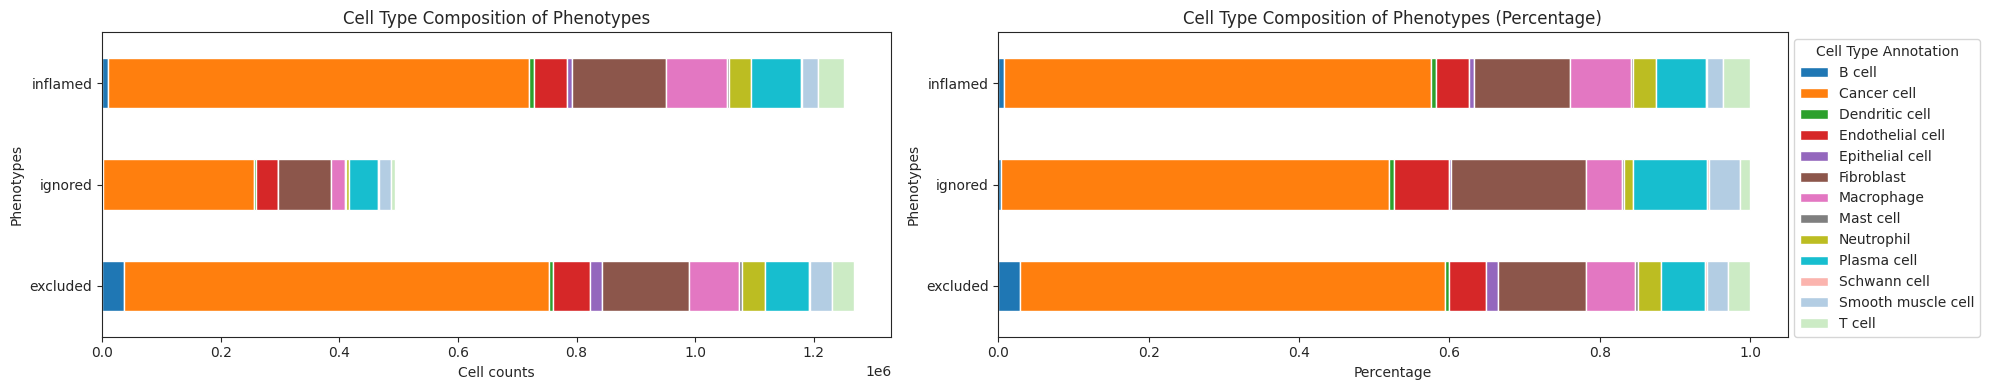

In [9]:
df_counts = (adata.obs.groupby([phenotype_key, cell_type_key]).size().unstack())
df_percent = df_counts.div(df_counts.sum(axis=1), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

df_counts.plot(kind="barh", stacked=True, ax=ax1, color=combined_colors[:len(df_counts.columns)],legend=False)
ax1.set_title("Cell Type Composition of Phenotypes")
ax1.set_xlabel("Cell counts")
ax1.set_ylabel("Phenotypes")

df_percent.plot(kind="barh", stacked=True, color=combined_colors[:len(df_percent.columns)], ax=ax2)
legend = ax2.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotation", prop={'size': 10})
ax2.set_title("Cell Type Composition of Phenotypes (Percentage)")
ax2.set_xlabel("Percentage")
ax2.set_ylabel("Phenotypes")

plt.tight_layout()
#plt.savefig(f"{figure_folder_path}/7_niches.svg", bbox_inches="tight")
plt.show()

In [10]:
df_percent

celltype,B cell,Cancer cell,Dendritic cell,Endothelial cell,Epithelial cell,Fibroblast,Macrophage,Mast cell,Neutrophil,Plasma cell,Schwann cell,Smooth muscle cell,T cell
phenotype,,,,,,,,,,,,,
excluded,0.029402,0.565345,0.005330,0.048546,0.016193,0.116400,0.066251,0.003345,0.030960,0.058588,0.001868,0.029192,0.028580
ignored,0.003114,0.516623,0.006026,0.073668,0.003159,0.178927,0.047830,0.003315,0.011312,0.098236,0.003714,0.040515,0.013563
inflamed,0.007802,0.567456,0.006694,0.044574,0.005984,0.127411,0.081661,0.002921,0.030084,0.067162,0.001111,0.021704,0.035437


In [ ]:
# IF MULTILEVEL
# reference_cell_type parameter is used to specify a cell type that is believed to be unchanged by the covariates
# cell type that has a nearly constant relative abundance over all samples
# It is also possible to let scCODA find a suited reference cell type by using reference_cell_type="automatic"
# formula="Cov1 + Cov2 + Cov3"
# model = mod.CompositionalAnalysis(adata_sccoda, formula="C(phenotype, Treatment('ignored'))", reference_cell_type="Schwann cell")

## scCODA - excluded vs inflamed

In [56]:
# retain only inflamed and exluded for now
adata_infl_excl = adata[adata.obs[phenotype_key].isin(['inflamed', 'excluded'])].copy()

In [57]:
cell_counts_per_patient_infl_excl = (adata_infl_excl.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_infl_excl[phenotype_key] = adata_infl_excl.obs.groupby(patient_key)[phenotype_key].first()

In [58]:
# Convert data to anndata object
adata_sccoda_infl_excl = dat.from_pandas(cell_counts_per_patient_infl_excl, covariate_columns=[phenotype_key])
adata_sccoda_infl_excl

AnnData object with n_obs × n_vars = 11 × 13
    obs: 'phenotype'

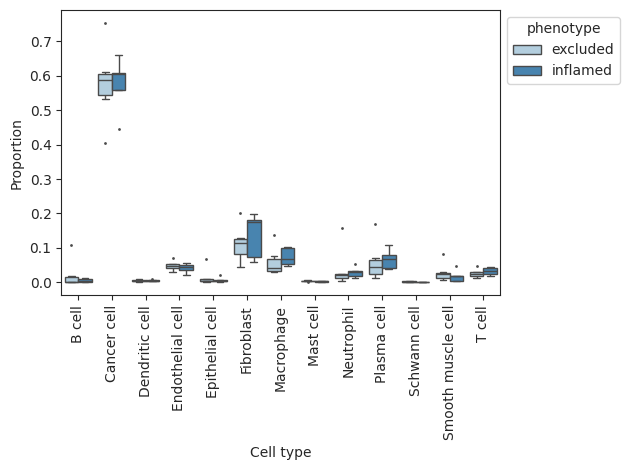

In [59]:
viz.boxplots(adata_sccoda_infl_excl, feature_name=phenotype_key)
plt.show()

### Automatic reference

In [60]:
model_infl_excl = mod.CompositionalAnalysis(adata_sccoda_infl_excl, formula=phenotype_key, reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to Mast cell


In [120]:
results_infl_excl = model_infl_excl.sample_hmc()

100%|██████████| 20000/20000 [01:15<00:00, 265.70it/s]


MCMC sampling finished. (96.018 sec)
Acceptance rate: 50.0%


In [121]:
results_infl_excl.set_fdr(est_fdr=0.4)
results_infl_excl.summary()

Compositional Analysis summary:

Data: 11 samples, 13 cell types
Reference index: 7
Formula: phenotype

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
B cell                       -0.574      2331.215984
Cancer cell                   3.466    132474.478688
Dendritic cell               -0.491      2532.963632
Endothelial cell              1.040     11709.377461
Epithelial cell              -0.487      2543.115777
Fibroblast                    1.857     26506.500723
Macrophage                    1.278     14855.794827
Mast cell                    -0.762      1931.679850
Neutrophil                    0.500      6823.619252
Plasma cell                   1.129     12799.294001
Schwann cell                 -1.121      1349.035663
Smooth muscle cell            0.278      5465.141499
T cell                        0.615      7655.237187


Effects:
                                          Final Parameter  Expected Sample  \


Effetti piccoli e non credibili:
Tutti i mean sono vicini a 0, e gli intervalli di credibilità (hdi_3%–hdi_97%) includono sempre 0, quindi non c’è alcun effetto chiaramente distinto dallo zero.
-> Non hai evidence bayesiana di una variazione significativa tra phenotype inflamed e reference per nessun tipo cellulare.

ESS (Effective Sample Size) è accettabile (600–2000) -> buona miscelazione della catena MCMC.

In [122]:
az.summary(results_infl_excl, var_names=["beta"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[phenotype[T.inflamed], B cell]",0.006,0.136,-0.286,0.290,0.004,0.005,1003.764,1959.241,NaN
"beta[phenotype[T.inflamed], Cancer cell]",0.009,0.072,-0.140,0.170,0.002,0.002,1124.589,1289.557,NaN
"beta[phenotype[T.inflamed], Dendritic cell]",0.020,0.139,-0.233,0.327,0.004,0.006,1041.303,1717.175,NaN
"beta[phenotype[T.inflamed], Endothelial cell]",-0.016,0.122,-0.272,0.247,0.003,0.004,864.710,1599.215,NaN
"beta[phenotype[T.inflamed], Epithelial cell]",-0.001,0.138,-0.262,0.322,0.004,0.005,826.340,1335.635,NaN
"beta[phenotype[T.inflamed], Fibroblast]",0.041,0.122,-0.152,0.328,0.004,0.005,870.004,1308.479,NaN
"beta[phenotype[T.inflamed], Macrophage]",0.048,0.144,-0.146,0.401,0.004,0.006,857.113,1570.874,NaN
"beta[phenotype[T.inflamed], Mast cell]",0.000,0.000,0.000,0.000,0.000,NaN,15000.000,15000.000,NaN
"beta[phenotype[T.inflamed], Neutrophil]",0.024,0.141,-0.224,0.347,0.004,0.006,833.159,1418.885,NaN
"beta[phenotype[T.inflamed], Plasma cell]",0.052,0.146,-0.163,0.394,0.005,0.005,702.608,1581.183,NaN


### Looping on all cell types as reference

In [ ]:
# Run scCODA with each cell type as the reference
cell_types = adata_sccoda_infl_excl.var.index
results_cycle_infl_excl = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(adata_sccoda, formula=phenotype_key, reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    temp_results.set_fdr(est_fdr=0.4)
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle_infl_excl["times_credible"] += cred_eff.astype("int")

Reference: B cell


100%|██████████| 20000/20000 [03:07<00:00, 106.70it/s]


MCMC sampling finished. (235.231 sec)
Acceptance rate: 51.3%
Reference: Cancer cell


100%|██████████| 20000/20000 [03:06<00:00, 107.20it/s]


MCMC sampling finished. (234.185 sec)
Acceptance rate: 44.7%
Reference: Dendritic cell


100%|██████████| 20000/20000 [03:06<00:00, 107.42it/s]


MCMC sampling finished. (234.209 sec)
Acceptance rate: 66.0%
Reference: Endothelial cell


100%|██████████| 20000/20000 [03:07<00:00, 106.73it/s]


MCMC sampling finished. (235.308 sec)
Acceptance rate: 44.6%
Reference: Epithelial cell


100%|██████████| 20000/20000 [03:08<00:00, 106.37it/s]


MCMC sampling finished. (236.017 sec)
Acceptance rate: 55.9%
Reference: Fibroblast


100%|██████████| 20000/20000 [03:07<00:00, 106.69it/s]


MCMC sampling finished. (235.977 sec)
Acceptance rate: 55.6%
Reference: Macrophage


100%|██████████| 20000/20000 [03:06<00:00, 106.99it/s]


MCMC sampling finished. (234.759 sec)
Acceptance rate: 54.3%
Reference: Mast cell


100%|██████████| 20000/20000 [03:05<00:00, 107.85it/s]


MCMC sampling finished. (234.054 sec)
Acceptance rate: 54.5%
Reference: Neutrophil


100%|██████████| 20000/20000 [03:10<00:00, 105.20it/s]


MCMC sampling finished. (238.816 sec)
Acceptance rate: 51.2%
Reference: Plasma cell


100%|██████████| 20000/20000 [03:06<00:00, 107.35it/s]


MCMC sampling finished. (235.417 sec)
Acceptance rate: 49.7%
Reference: Schwann cell


100%|██████████| 20000/20000 [03:07<00:00, 106.58it/s]


MCMC sampling finished. (236.479 sec)
Acceptance rate: 49.2%
Reference: Smooth muscle cell


100%|██████████| 20000/20000 [03:05<00:00, 107.64it/s]


MCMC sampling finished. (234.027 sec)
Acceptance rate: 67.9%
Reference: T cell


 93%|█████████▎| 18571/20000 [02:52<00:13, 104.59it/s]

In [27]:
# Calculate percentages
results_cycle_infl_excl["pct_credible"] = results_cycle_infl_excl["times_credible"]/len(cell_types)
results_cycle_infl_excl["is_credible"] = results_cycle_infl_excl["pct_credible"] > 0.5
print(results_cycle_infl_excl)

                    times_credible  pct_credible  is_credible
celltype                                                     
B cell                           0           0.0        False
Cancer cell                      0           0.0        False
Dendritic cell                   0           0.0        False
Endothelial cell                 0           0.0        False
Epithelial cell                  0           0.0        False
Fibroblast                       0           0.0        False
Macrophage                       0           0.0        False
Mast cell                        0           0.0        False
Neutrophil                       0           0.0        False
Plasma cell                      0           0.0        False
Schwann cell                     0           0.0        False
Smooth muscle cell               0           0.0        False
T cell                           0           0.0        False


## scCODA - ignored vs inflamed

In [64]:
adata_infl_ign = adata[adata.obs[phenotype_key].isin(['inflamed', 'ignored'])].copy()

In [65]:
cell_counts_per_patient_infl_ign = (adata_infl_ign.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_infl_ign[phenotype_key] = adata_infl_ign.obs.groupby(patient_key)[phenotype_key].first()

In [66]:
# Convert data to anndata object
adata_sccoda_infl_ign = dat.from_pandas(cell_counts_per_patient_infl_ign, covariate_columns=[phenotype_key])
adata_sccoda_infl_ign

AnnData object with n_obs × n_vars = 9 × 13
    obs: 'phenotype'

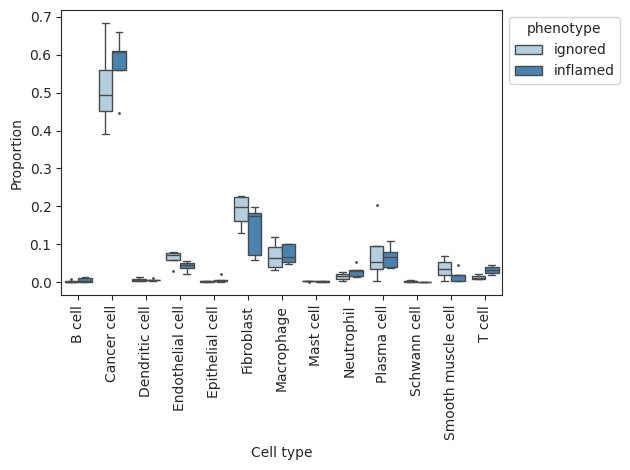

In [67]:
viz.boxplots(adata_sccoda_infl_ign, feature_name=phenotype_key)
plt.show()

### Automatic reference

In [68]:
model_infl_ign = mod.CompositionalAnalysis(adata_sccoda_infl_ign, formula=phenotype_key, reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to Mast cell


In [117]:
results_infl_ign = model_infl_ign.sample_hmc()

100%|██████████| 20000/20000 [01:13<00:00, 272.16it/s]


MCMC sampling finished. (93.533 sec)
Acceptance rate: 56.6%


In [118]:
results_infl_ign.set_fdr(est_fdr=0.4)
results_infl_ign.summary()

Compositional Analysis summary:

Data: 9 samples, 13 cell types
Reference index: 7
Formula: phenotype

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
B cell                       -0.707      1582.332102
Cancer cell                   3.473    103430.487945
Dendritic cell               -0.301      2374.768058
Endothelial cell              1.249     11188.648897
Epithelial cell              -0.601      1759.271447
Fibroblast                    2.318     32586.554773
Macrophage                    1.477     14053.897691
Mast cell                    -0.646      1681.859074
Neutrophil                    0.377      4678.136154
Plasma cell                   1.119      9824.701474
Schwann cell                 -0.992      1189.936296
Smooth muscle cell            0.363      4613.098574
T cell                        0.432      4942.640848


Effects:
                                          Final Parameter  Expected Sample  \
C

In [119]:
az.summary(results_infl_ign, var_names=["beta"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[phenotype[T.inflamed], B cell]",0.047,0.208,-0.271,0.583,0.005,0.006,1310.638,2646.162,NaN
"beta[phenotype[T.inflamed], Cancer cell]",0.103,0.164,-0.056,0.484,0.007,0.004,558.507,2003.603,NaN
"beta[phenotype[T.inflamed], Dendritic cell]",0.006,0.190,-0.376,0.454,0.004,0.006,1492.589,2702.452,NaN
"beta[phenotype[T.inflamed], Endothelial cell]",-0.062,0.178,-0.515,0.196,0.005,0.005,1346.062,2284.990,NaN
"beta[phenotype[T.inflamed], Epithelial cell]",0.027,0.198,-0.340,0.514,0.005,0.006,1427.651,2349.293,NaN
"beta[phenotype[T.inflamed], Fibroblast]",-0.115,0.187,-0.528,0.100,0.006,0.004,732.362,2874.282,NaN
"beta[phenotype[T.inflamed], Macrophage]",0.044,0.162,-0.201,0.461,0.004,0.005,1234.007,1951.964,NaN
"beta[phenotype[T.inflamed], Mast cell]",0.000,0.000,0.000,0.000,0.000,NaN,15000.000,15000.000,NaN
"beta[phenotype[T.inflamed], Neutrophil]",0.120,0.260,-0.241,0.716,0.010,0.010,764.023,1335.479,NaN
"beta[phenotype[T.inflamed], Plasma cell]",0.167,0.270,-0.118,0.785,0.010,0.006,559.269,650.238,NaN


In [ ]:
# sd quite high

### Looping on all cell types as reference

In [12]:
# Run scCODA with each cell type as the reference
cell_types = adata_sccoda_infl_ign.var.index
results_cycle_infl_ign = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(adata_sccoda, formula=phenotype_key, reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    temp_results.set_fdr(est_fdr=0.4)
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle_infl_ign["times_credible"] += cred_eff.astype("int")

Reference: B cell


100%|██████████| 20000/20000 [01:14<00:00, 269.69it/s]


MCMC sampling finished. (94.510 sec)
Acceptance rate: 49.9%
Reference: Cancer cell


100%|██████████| 20000/20000 [01:14<00:00, 269.68it/s]


MCMC sampling finished. (94.448 sec)
Acceptance rate: 61.3%
Reference: Dendritic cell


100%|██████████| 20000/20000 [01:13<00:00, 271.69it/s]


MCMC sampling finished. (93.932 sec)
Acceptance rate: 49.3%
Reference: Endothelial cell


100%|██████████| 20000/20000 [01:14<00:00, 269.90it/s]


MCMC sampling finished. (94.651 sec)
Acceptance rate: 74.6%
Reference: Epithelial cell


100%|██████████| 20000/20000 [01:12<00:00, 274.59it/s]


MCMC sampling finished. (92.613 sec)
Acceptance rate: 10.7%
Reference: Fibroblast


100%|██████████| 20000/20000 [01:13<00:00, 270.80it/s]


MCMC sampling finished. (94.156 sec)
Acceptance rate: 71.5%
Reference: Macrophage


100%|██████████| 20000/20000 [01:14<00:00, 269.20it/s]


MCMC sampling finished. (94.754 sec)
Acceptance rate: 62.5%
Reference: Mast cell


100%|██████████| 20000/20000 [01:13<00:00, 271.05it/s]


MCMC sampling finished. (93.904 sec)
Acceptance rate: 8.2%
Reference: Neutrophil


100%|██████████| 20000/20000 [01:12<00:00, 274.58it/s]


MCMC sampling finished. (92.602 sec)
Acceptance rate: 19.4%
Reference: Plasma cell


100%|██████████| 20000/20000 [01:13<00:00, 271.87it/s]


MCMC sampling finished. (93.990 sec)
Acceptance rate: 56.1%
Reference: Schwann cell


100%|██████████| 20000/20000 [01:12<00:00, 275.78it/s]


MCMC sampling finished. (92.559 sec)
Acceptance rate: 8.7%
Reference: Smooth muscle cell


100%|██████████| 20000/20000 [01:14<00:00, 269.66it/s]


MCMC sampling finished. (94.630 sec)
Acceptance rate: 67.5%
Reference: T cell


100%|██████████| 20000/20000 [01:13<00:00, 271.45it/s]


MCMC sampling finished. (94.369 sec)
Acceptance rate: 0.0%


In [13]:
# Calculate percentages
results_cycle_infl_ign["pct_credible"] = results_cycle_infl_ign["times_credible"]/len(cell_types)
results_cycle_infl_ign["is_credible"] = results_cycle_infl_ign["pct_credible"] > 0.5
print(results_cycle_infl_ign)

                    times_credible  pct_credible  is_credible
celltype                                                     
B cell                           2      0.153846        False
Cancer cell                      6      0.461538        False
Dendritic cell                   1      0.076923        False
Endothelial cell                 1      0.076923        False
Epithelial cell                  0      0.000000        False
Fibroblast                       7      0.538462         True
Macrophage                       1      0.076923        False
Mast cell                        2      0.153846        False
Neutrophil                       3      0.230769        False
Plasma cell                      9      0.692308         True
Schwann cell                     3      0.230769        False
Smooth muscle cell               1      0.076923        False
T cell                           9      0.692308         True


## scCODA - ignored vs excluded

In [73]:
adata_excl_ign = adata[adata.obs[phenotype_key].isin(['excluded', 'ignored'])].copy()

In [74]:
cell_counts_per_patient_excl_ign = (adata_excl_ign.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_excl_ign[phenotype_key] = adata_excl_ign.obs.groupby(patient_key)[phenotype_key].first()

In [75]:
# Convert data to anndata object
adata_sccoda_excl_ign = dat.from_pandas(cell_counts_per_patient_excl_ign, covariate_columns=[phenotype_key])
adata_sccoda_excl_ign

AnnData object with n_obs × n_vars = 10 × 13
    obs: 'phenotype'

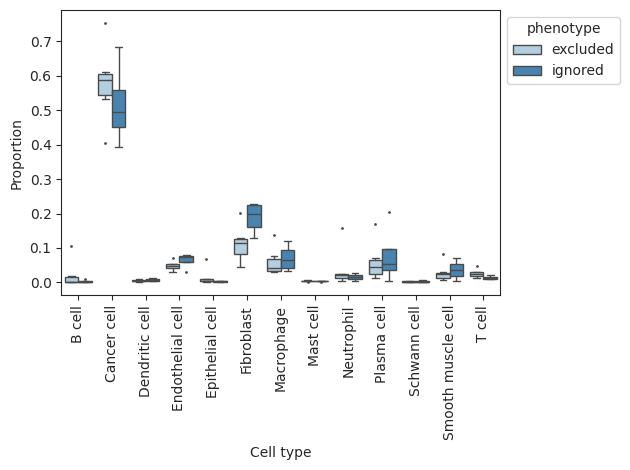

In [76]:
viz.boxplots(adata_sccoda_excl_ign, feature_name=phenotype_key)
plt.show()

### Automatic reference

In [77]:
model_excl_ign = mod.CompositionalAnalysis(adata_sccoda_excl_ign, formula=phenotype_key, reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to Mast cell


In [113]:
results_excl_ign = model_excl_ign.sample_hmc()

100%|██████████| 20000/20000 [01:13<00:00, 271.13it/s]


MCMC sampling finished. (93.733 sec)
Acceptance rate: 58.3%


In [114]:
results_excl_ign.set_fdr(est_fdr=0.4)
results_excl_ign.summary()

Compositional Analysis summary:

Data: 10 samples, 13 cell types
Reference index: 7
Formula: phenotype

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
B cell                       -0.805      1862.089604
Cancer cell                   3.168     98958.374321
Dendritic cell               -0.651      2172.110554
Endothelial cell              0.930     10556.051531
Epithelial cell              -0.676      2118.480953
Fibroblast                    1.682     22391.900313
Macrophage                    0.988     11186.406103
Mast cell                    -0.836      1805.250386
Neutrophil                    0.103      4616.788347
Plasma cell                   0.716      8522.411156
Schwann cell                 -1.057      1447.299347
Smooth muscle cell            0.276      5488.743180
T cell                        0.172      4946.594205


Effects:
                                         Final Parameter  Expected Sample  \
C

In [115]:
az.summary(results_excl_ign, var_names=["beta"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[phenotype[T.ignored], B cell]",-0.023,0.189,-0.404,0.349,0.004,0.009,1715.844,2606.772,NaN
"beta[phenotype[T.ignored], Cancer cell]",-0.039,0.117,-0.358,0.119,0.003,0.003,1237.892,2475.239,NaN
"beta[phenotype[T.ignored], Dendritic cell]",0.017,0.174,-0.305,0.438,0.004,0.005,1532.387,1863.652,NaN
"beta[phenotype[T.ignored], Endothelial cell]",0.040,0.163,-0.263,0.419,0.003,0.004,1588.538,2715.402,NaN
"beta[phenotype[T.ignored], Epithelial cell]",-0.035,0.195,-0.500,0.322,0.005,0.007,1419.037,2102.804,NaN
"beta[phenotype[T.ignored], Fibroblast]",0.229,0.268,-0.101,0.748,0.009,0.003,703.191,516.430,NaN
"beta[phenotype[T.ignored], Macrophage]",0.027,0.152,-0.249,0.392,0.003,0.004,2094.599,3440.881,NaN
"beta[phenotype[T.ignored], Mast cell]",0.000,0.000,0.000,0.000,0.000,NaN,15000.000,15000.000,NaN
"beta[phenotype[T.ignored], Neutrophil]",-0.039,0.181,-0.505,0.251,0.004,0.005,1836.930,3031.410,NaN
"beta[phenotype[T.ignored], Plasma cell]",-0.021,0.157,-0.392,0.268,0.003,0.005,1820.227,2979.637,NaN


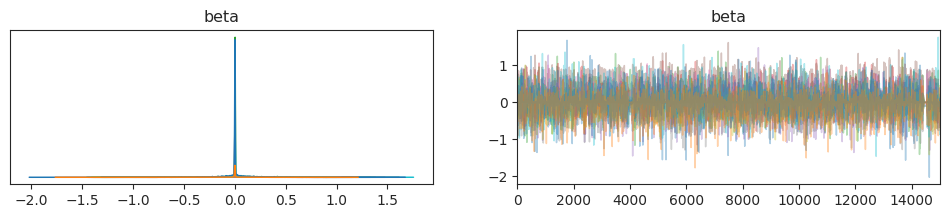

In [116]:
az.plot_trace(
    results_excl_ign,
    divergences=False,
    var_names=["beta"],
    coords={"cell_type": results_excl_ign.posterior.coords["cell_type_nb"]},
)
plt.show()

### Looping on all cell types as reference

In [24]:
# Run scCODA with each cell type as the reference
cell_types = adata_sccoda_excl_ign.var.index
results_cycle_excl_ign = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(adata_sccoda, formula=phenotype_key, reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    temp_results.set_fdr(est_fdr=0.4)
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle_excl_ign["times_credible"] += cred_eff.astype("int")

Reference: B cell


100%|██████████| 20000/20000 [01:15<00:00, 265.99it/s]


MCMC sampling finished. (96.098 sec)
Acceptance rate: 68.7%
Reference: Cancer cell


100%|██████████| 20000/20000 [01:14<00:00, 269.25it/s]


MCMC sampling finished. (94.854 sec)
Acceptance rate: 55.0%
Reference: Dendritic cell


100%|██████████| 20000/20000 [01:14<00:00, 268.98it/s]


MCMC sampling finished. (94.894 sec)
Acceptance rate: 55.4%
Reference: Endothelial cell


100%|██████████| 20000/20000 [01:14<00:00, 269.39it/s]


MCMC sampling finished. (94.792 sec)
Acceptance rate: 58.9%
Reference: Epithelial cell


100%|██████████| 20000/20000 [01:14<00:00, 268.64it/s]


MCMC sampling finished. (95.061 sec)
Acceptance rate: 61.4%
Reference: Fibroblast


100%|██████████| 20000/20000 [01:14<00:00, 269.63it/s]


MCMC sampling finished. (94.535 sec)
Acceptance rate: 54.2%
Reference: Macrophage


100%|██████████| 20000/20000 [01:14<00:00, 267.99it/s]


MCMC sampling finished. (95.387 sec)
Acceptance rate: 61.2%
Reference: Mast cell


100%|██████████| 20000/20000 [01:14<00:00, 268.30it/s]


MCMC sampling finished. (95.196 sec)
Acceptance rate: 53.4%
Reference: Neutrophil


100%|██████████| 20000/20000 [01:13<00:00, 273.26it/s]


MCMC sampling finished. (93.402 sec)
Acceptance rate: 0.0%
Reference: Plasma cell


100%|██████████| 20000/20000 [01:14<00:00, 268.67it/s]


MCMC sampling finished. (95.015 sec)
Acceptance rate: 53.8%
Reference: Schwann cell


100%|██████████| 20000/20000 [01:14<00:00, 268.05it/s]


MCMC sampling finished. (95.218 sec)
Acceptance rate: 58.9%
Reference: Smooth muscle cell


100%|██████████| 20000/20000 [01:14<00:00, 268.59it/s]


MCMC sampling finished. (95.090 sec)
Acceptance rate: 55.8%
Reference: T cell


100%|██████████| 20000/20000 [01:15<00:00, 266.36it/s]


MCMC sampling finished. (95.852 sec)
Acceptance rate: 51.0%


In [25]:
# Calculate percentages
results_cycle_excl_ign["pct_credible"] = results_cycle_excl_ign["times_credible"]/len(cell_types)
results_cycle_excl_ign["is_credible"] = results_cycle_excl_ign["pct_credible"] > 0.5
print(results_cycle_excl_ign)

                    times_credible  pct_credible  is_credible
celltype                                                     
B cell                           1      0.076923        False
Cancer cell                      0      0.000000        False
Dendritic cell                   1      0.076923        False
Endothelial cell                 0      0.000000        False
Epithelial cell                  6      0.461538        False
Fibroblast                      12      0.923077         True
Macrophage                       1      0.076923        False
Mast cell                        1      0.076923        False
Neutrophil                       0      0.000000        False
Plasma cell                      0      0.000000        False
Schwann cell                     1      0.076923        False
Smooth muscle cell               0      0.000000        False
T cell                           1      0.076923        False
